In [1]:
%load_ext autoreload
%autoreload 2

This notebook visualizes a trained 2-d LTC model on the Banana source. Prior to running the notebook, the LTC model needs to be trained. Use
```
python train_model.py --n 1 --d 2 --dy 2 --n_train_samples 1000000 --num_eval_samples 1000000 --model_name "LTCDither" --data_name "Banana" --transform_name "MLP2" --eb_name "FactorizedPrior" --lattice_name "HexagonalUnitVol" --lam_sweep 32 --epochs 1 --save
```
which will save the trained model in ``trained/Banana``.

In [2]:
from LTC.layers import LTC
import LTC.data as data
import torch
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from colorhash import ColorHash

/workspace/envs/ltc/lib/python3.11/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [3]:
import itertools
C_colors_fixed = [[0.8352941176470589, 0.8676470588235294, 0.38235294117647056], [0.6441176470588236, 0.47352941176470587, 0.38235294117647056], [0.6029411764705882, 0.44411764705882356, 0.42058823529411765], [0.38235294117647056, 0.7382352941176471, 0.8676470588235294], [0.6264705882352941, 0.8117647058823529, 0.43823529411764706], [0.6058823529411764, 0.7147058823529412, 0.8676470588235294], [0.6911764705882353, 0.6470588235294118, 0.8294117647058824], [0.6911764705882353, 0.6470588235294118, 0.8294117647058824], [0.6911764705882353, 0.6470588235294118, 0.8294117647058824], [0.6441176470588236, 0.5352941176470588, 0.38235294117647056], [0.6441176470588236, 0.5352941176470588, 0.38235294117647056], [0.6441176470588236, 0.5352941176470588, 0.38235294117647056], [0.8117647058823529, 0.44411764705882356, 0.43823529411764706], [0.6470588235294118, 0.65, 0.8294117647058824], [0.6323529411764706, 0.3411764705882353, 0.6823529411764706], [0.7558823529411764, 0.7264705882352941, 0.49411764705882355], [0.7558823529411764, 0.7264705882352941, 0.49411764705882355], [0.7558823529411764, 0.7264705882352941, 0.49411764705882355], [0.43823529411764706, 0.8117647058823529, 0.7176470588235294], [0.8117647058823529, 0.5264705882352941, 0.43823529411764706], [0.6470588235294118, 0.8294117647058824, 0.7029411764705882], [0.6029411764705882, 0.42058823529411765, 0.5205882352941176], [0.6029411764705882, 0.42058823529411765, 0.5205882352941176], [0.6029411764705882, 0.42058823529411765, 0.5205882352941176], [0.8676470588235294, 0.38235294117647056, 0.5029411764705882], [0.8676470588235294, 0.38235294117647056, 0.5029411764705882], [0.8676470588235294, 0.38235294117647056, 0.5029411764705882], [0.6441176470588236, 0.4294117647058824, 0.38235294117647056], [0.6441176470588236, 0.4294117647058824, 0.38235294117647056], [0.6441176470588236, 0.4294117647058824, 0.38235294117647056], [0.6441176470588236, 0.38235294117647056, 0.3911764705882353], [0.6029411764705882, 0.42058823529411765, 0.5411764705882354], [0.8205882352941176, 0.6470588235294118, 0.8294117647058824], [0.6029411764705882, 0.6441176470588236, 0.38235294117647056], [0.43823529411764706, 0.7, 0.8117647058823529], [0.43823529411764706, 0.7, 0.8117647058823529], [0.43823529411764706, 0.7, 0.8117647058823529], [0.6029411764705882, 0.5735294117647058, 0.42058823529411765], [0.9088235294117647, 0.5676470588235294, 0.7147058823529412], [0.45, 0.6029411764705882, 0.42058823529411765], [0.45, 0.6029411764705882, 0.42058823529411765], [0.45, 0.6029411764705882, 0.42058823529411765], [0.6294117647058823, 0.38235294117647056, 0.6441176470588236], [0.7676470588235293, 0.6058823529411764, 0.8676470588235294], [0.5941176470588235, 0.43823529411764706, 0.8117647058823529], [0.7558823529411764, 0.49411764705882355, 0.6264705882352941], [0.4470588235294118, 0.6441176470588236, 0.38235294117647056], [0.7558823529411764, 0.49411764705882355, 0.6647058823529413]]
def plot_quantizer2(x, x_hat, y, y_hat, y_unif=None, lik=None):
    C2 = torch.unique(torch.cat((x_hat, y_hat), dim=1), dim=0)
    C, C_latent = C2[:,:2], C2[:,2:]

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    colors = C_colors_fixed
    color_iter = itertools.cycle(colors)
    C_colors = []
    Ms = []
    latent_dist = []
    plt.figure(1, figsize=(4.5, 4.5), constrained_layout=True)
    # plt.subplot(1, 2, 1)
    for i in range(C_latent.shape[0]):
        M = np.all(y_hat.numpy() == C_latent[i, :].numpy(), axis=1)
        Ms.append(M)
        # print(np.sum(M) / len(M))
        latent_dist.append(np.sum(M) / len(M)) # append frequency
        # color_i = np.random.rand(3) * 0.5 + 0.5
        color_i = list((np.array(ColorHash(C_latent[i,:]).rgb, dtype=float) / 255) * 0.7 + 0.3)
        # color_i = next(color_iter)
        C_colors.append(color_i)
        plt.scatter(y[M,0], y[M,1], s=1, alpha=0.75, color=color_i)
    plt.scatter(C_latent[:, 0], C_latent[:, 1], marker='o', c='black', edgecolors='black', s=20, label=r'$\hat{Y}$')
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlim([-2.2, 2.2])
    plt.ylim([-2.2, 2.2])
    plt.axis('off')



    # plt.subplot(1, 2, 2)
    plt.figure(2, figsize=(4.5, 4.5), constrained_layout=True)
    for i in range(C.shape[0]):
        M = Ms[i]
        plt.scatter(x[M,0], x[M,1], s=2, alpha=0.75, color=C_colors[i])
    # plt.scatter(C[:, 0], C[:, 1], marker='o', c=np.array(C_colors), edgecolors='salmon', s=50, label=r'$\hat{X}$')
    plt.scatter(C[:, 0], C[:, 1], marker='o', c='black', edgecolors='black', s=40, label=r'$\hat{X}$')
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlim([-2.5, 4])
    plt.ylim([-1.25, 3])
    plt.axis('off')
    print(C_colors)



## Companders

### Hexagonal Lattice

In [4]:
device = 'cuda:0'

In [5]:
source = 'Banana'
eb_name = 'FactorizedPrior'
lattice = 'HexagonalUnitVol'
tname = 'MLP2'
model_name = 'LTCDither'
n=1
lam = 32.0
model = LTC(d=2, dy=2, d_hidden=100, lattice=lattice, tname=tname, eb_name=eb_name)
saved = torch.load(f'trained/{source}/{model_name}_{lattice}_{tname}_{eb_name}_n{n}_d2_dy2_Nint2048_lam{lam}.pt', map_location='cpu')
model.load_state_dict(saved)
model = model.to(device)

/tmp/ipykernel_19367/2212956623.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(f'trained/{source}/{model_name}_{lattice}_{tname}_{eb_name}_n{n}_d2_dy

In [6]:
# generate reconstructions
# import data
loader = data.Banana(30000)
# loader = data.Gaussian(n=2, batch_size=50000)
it = iter(loader)
x = next(it)[0]
# x = torch.rand(150000, 2)
# x[:,0] = x[:,0]*8 - 3
# x[:,1] = x[:,1]*7 -2
x = x.to(device) 
model = model.to(device)
# xq, lik = model.forward(x)
xq = []
lik = []
y = []
y_hat = []
bsize = 200
for i in tqdm.trange(len(x) // bsize):
    xq1, lik1, y1, y_hat1 = model.eval(x[i*bsize:i*bsize+bsize], return_y=True)
    xq.append(xq1.detach().cpu())
    lik.append(lik1.detach().cpu())
    y.append(y1.detach().cpu())
    y_hat.append(y_hat1.detach().cpu())
xq = torch.cat(xq)
lik = torch.cat(lik)
y = torch.cat(y)
y_hat = torch.cat(y_hat)
x = x.cpu()
print(f'rate={torch.sum(-torch.log2(lik)) / (lik.shape[0]*n)}, distortion={torch.mean((x-xq)**2)}')
# xq = xq.detach().cpu()
# lik = lik.detach().cpu()
# y = y.detach().cpu()
# y_hat = y_hat.detach().cpu()
# xq, idx = Q(x, retidx=True)

100%|██████████| 150/150 [00:01<00:00, 75.74it/s] 

rate=4.344161033630371, distortion=0.03745177388191223


[[0.6294117647058823, 0.58, 0.4592156862745098], [0.5223529411764706, 0.824313725490196, 0.4756862745098039], [0.8764705882352941, 0.632156862745098, 0.6843137254901961], [0.5635294117647058, 0.7721568627450981, 0.527843137254902], [0.632156862745098, 0.8764705882352941, 0.7090196078431372], [0.8764705882352941, 0.6705882352941176, 0.632156862745098], [0.6294117647058823, 0.4592156862745098, 0.5552941176470587], [0.5964705882352941, 0.9149019607843136, 0.6486274509803922], [0.48392156862745095, 0.667843137254902, 0.4235294117647059], [0.7831372549019607, 0.632156862745098, 0.8764705882352941], [0.6705882352941176, 0.8407843137254902, 0.7666666666666666], [0.4756862745098039, 0.824313725490196, 0.5168627450980392], [0.6650980392156862, 0.5964705882352941, 0.9149019607843136], [0.6211764705882352, 0.4756862745098039, 0.824313725490196], [0.9149019607843136, 0.5964705882352941, 0.7337254901960784], [0.6294117647058823, 0.667843137254902, 0.4235294117647059], [0.48666666666666664, 0.629411

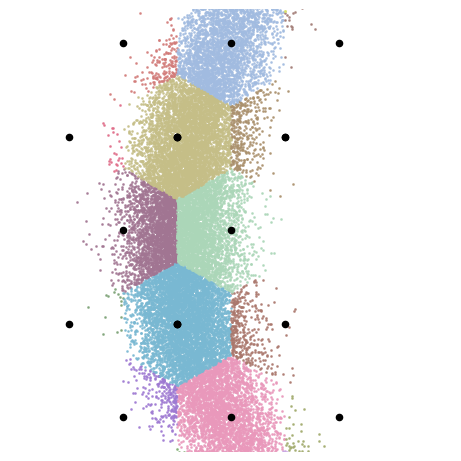

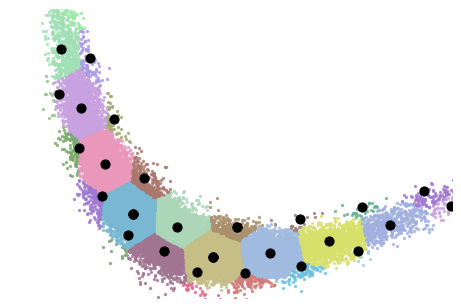

In [7]:
plot_quantizer2(x, xq, y, y_hat)